In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats

import matplotlib.pyplot as plt

pd.options.display.multi_sparse = False
sns.set(color_codes=True)
plt.style.use('fivethirtyeight')

%matplotlib inline

In [8]:
data = pd.read_csv('GlobalElections_US_all.csv')

We'll take only the relevant colums: year, type of election, district, total votes, and Democratic and Republican votes

In [9]:
elections = data[['year', 'legid', 'district', 'dtv', 'dm', 'p1s', 'p1v', 'p2s','p2v']]

In [10]:
elections.head(5)

,year,legid,district,dtv,dm,p1s,p1v,p2s,p2v
0,1986,2,Wisconsin,1483174,1,0,702963,1,754573
1,1986,2,Washington,1337367,1,1,677471,0,650931
2,1986,2,Utah,435111,1,0,115523,1,314608
3,1986,2,Vermont,196532,1,1,124123,0,67798
4,1986,2,South Dakota,295830,1,1,152657,0,143173


We'll parse out the state name from each district

In [11]:
elections.loc[:,'state'] = elections.loc[:,'district'].apply(lambda x: x.split('-')[0])

In [22]:
states = list(elections['state'].unique())
sorted(states)

['Alabama',
 'Alaska',
 'Arizona',
 'Arkansas',
 'California',
 'Colorado',
 'Connecticut',
 'Delaware',
 'Florida',
 'Georgia',
 'Hawaii',
 'Idaho',
 'Illinois',
 'Indiana',
 'Iowa',
 'Kansas',
 'Kentucky',
 'Louisiana',
 'Maine',
 'Maryland',
 'Massachusetts',
 'Michigan',
 'Minnesota',
 'Mississippi',
 'Missouri',
 'Montana',
 'Nebraska',
 'Nevada',
 'New Hampshire',
 'New Jersey',
 'New Mexico',
 'New York',
 'North Carolina',
 'North Dakota',
 'Ohio',
 'Oklahoma',
 'Oregon',
 'Pennsylvania',
 'Rhode Island',
 'South Carolina',
 'South Dakota',
 'Tennessee',
 'Texas',
 'Utah',
 'Vermont',
 'Virginia',
 'Washington',
 'West Virginia',
 'Wisconsin',
 'Wyoming']

We'll sum up all the votes per district in each state

In [23]:
state_elections = elections.groupby(['year', 'legid', 'state'], as_index=False).sum()

Since each legid represent a type of election, we'll need to pivot this to the columns, so we can compare side by side later

In [24]:
state_elections_piv = pd.pivot_table(state_elections[['year', 'state', 'legid', 'p1v', 'p2v']],index=["year", "state"], 
               columns=["legid"],aggfunc=[np.sum])

Let's give this columns some better names. First we'll flatten the multi-index, then assign new names 

In [25]:
state_elections_piv.columns = state_elections_piv.columns.get_level_values(2)

In [26]:
state_elections_piv.columns

Int64Index([1, 2, 5, 1, 2, 5], dtype='int64', name=u'legid')

In [27]:
cols = ['dem_congress', 'dem_senate', 'dem_president', 
        'rep_congress', 'rep_senate', 'rep_president']
state_elections_piv.columns = ['dem_congress', 'dem_senate', 'dem_president', 
                               'rep_congress', 'rep_senate', 'rep_president']

In [28]:
elect = state_elections_piv.reset_index()

We'll lag up the prior election so be able to look at the correlation

In [29]:
elect.sort_values(by=['state', 'year'], inplace=True)

In [30]:
elect.loc[:, 'prior_year'] = elect.groupby('state')['year'].shift(1)

In [31]:
for c in cols:
    new_col = 'prior_' + c
    elect[new_col] = elect.groupby('state')[c].shift(1)

Let's compute margins etc

In [32]:
elect.loc[:,'senate_total'] = elect.loc[:,'rep_senate'] + elect.loc[:,'dem_senate']
elect.loc[:,'congress_total'] = elect.loc[:,'rep_congress'] + elect.loc[:,'dem_congress']
elect.loc[:,'prior_president_total'] = elect.loc[:,'prior_rep_president'] + elect.loc[:,'prior_dem_president']

elect.loc[:,'rep_senate_margin'] = (elect.loc[:,'rep_senate']/
                                    elect.loc[:,'senate_total']) - (elect.loc[:,'dem_senate']/
                                                                    elect.loc[:,'senate_total'])

elect.loc[:,'rep_congress_margin'] = (elect.loc[:,'rep_congress']/
                                     elect.loc[:,'congress_total']) - (elect.loc[:,'dem_congress']/
                                                                       elect.loc[:,'congress_total'])

elect.loc[:,'prior_rep_president_margin'] = (elect.loc[:,'prior_rep_president']/
                                         elect.loc[:,'prior_president_total']) - (elect.loc[:,'prior_dem_president']/
                                                                                  elect.loc[:,'prior_president_total'])

We'll look at only elections that had prior presidential elections

In [33]:
off_pres_cycle = elect[elect.prior_rep_president.notnull()]

In [34]:
sorted(off_pres_cycle.year.unique())

[1990, 1994, 1996, 1998]

In [36]:
off_pres_cycle.fillna(0,inplace=True)

In [50]:
years = sorted(off_pres_cycle.year.unique())
x_cols = ['state', 'prior_rep_president_margin']
y_cols = ['rep_congress_margin', 'rep_senate_margin']
cols = x_cols + y_cols

Let's look at these years one by one. (It'd be nice to just loop through the years, but matplotlib likes to just plot on the same graph if we loop)

In [116]:
def show_lin_relationship(data, year, cols):

    df = data[data.year.isin([year])][cols + ['prior_year']]

    prior_year = int(df['prior_year'].unique()[0])
    x = df[cols[1]]
    y = df[cols[2]]

    print '{0} {1}:{2}'.format(i, cols[1], cols[2])
    
    formula = 'y = {0}x + {1}'.format(slope, intercept)
    r2 = r_value**2
    print formula
    print 'p-value: \t', p_value#, std_err, 
    print 'R2: \t\t', r2
        
    plt.scatter(x, y, label='')
    plt.plot(x, slope*x + intercept, '-', label='{0}\nr2={1}'.format(formula, r2))
    plt.xlabel('{0} {1}'.format(prior_year, cols[1]))
    plt.ylabel('{0} {1}'.format(year, cols[2]))
    
    plt.legend(loc='lower right')

#     return sns.regplot(x=X, y=y)
    

#### 1996 Presidential > 1998 Senate Election

1998 prior_rep_president_margin:rep_senate_margin
y = 0.793088544496x + 0.0517908029185
p-value: 	0.000333346295318
R2: 		0.237331982364


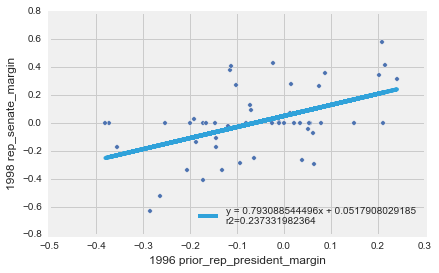

In [117]:
i = 1998
cols = ['state', 'prior_rep_president_margin', 'rep_senate_margin']
show_lin_relationship(off_pres_cycle, i, cols)

#### 1996 Presidential > 1998 Congressional Election

1998 prior_rep_president_margin:rep_congress_margin
y = 1.09115309147x + 0.104243308174
p-value: 	9.51103543251e-07
R2: 		0.396814518953


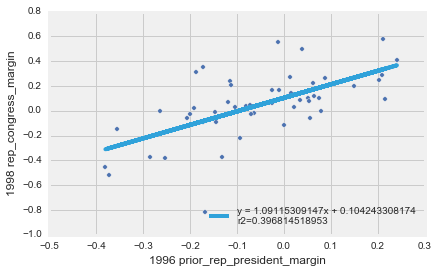

In [118]:
i = 1998
cols = ['state', 'prior_rep_president_margin', 'rep_congress_margin']

show_lin_relationship(off_pres_cycle, i, cols)

#### 1992 Presidential > 1994 Congressional Election

1994 prior_rep_president_margin:rep_congress_margin
y = 0.623287687321x + 0.0967130483032
p-value: 	0.00163571700308
R2: 		0.192054837709


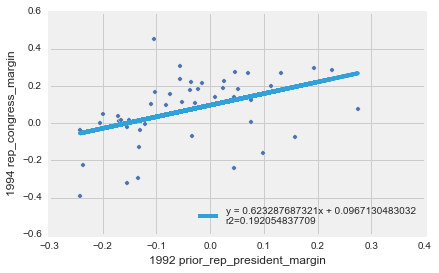

In [119]:
i = 1994
cols = ['state', 'prior_rep_president_margin', 'rep_congress_margin']

show_lin_relationship(off_pres_cycle, i, cols)

#### 1992 Presidential > 1994 Senate Election

1994 prior_rep_president_margin:rep_senate_margin
y = 0.423862521796x + 0.0553155343235
p-value: 	0.048572936784
R2: 		0.0802431322867


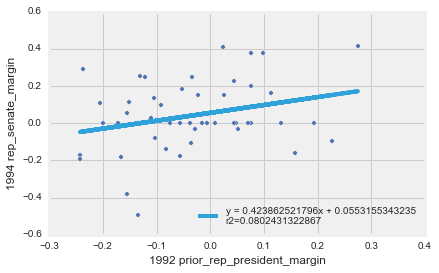

In [120]:
i = 1994
cols = ['state', 'prior_rep_president_margin', 'rep_senate_margin']

show_lin_relationship(off_pres_cycle, i, cols)

#### 1998 Presidential > 1990 Senate Election

1990 prior_rep_president_margin:rep_senate_margin
y = 0.511164099099x + -0.0559237978217
p-value: 	0.0603594946142
R2: 		0.0715639454839


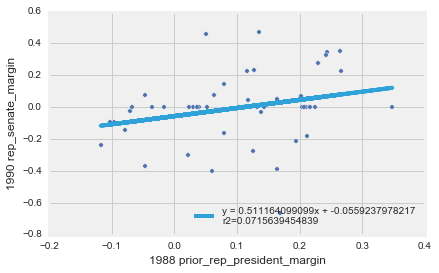

In [121]:
i = 1990
cols = ['state', 'prior_rep_president_margin', 'rep_senate_margin']
show_lin_relationship(off_pres_cycle, i, cols)

#### 1998 Presidential > 1990 Congressional Election

1990 prior_rep_president_margin:rep_congress_margin
y = 0.0541455369402x + -0.0865152195732
p-value: 	0.8436514397
R2: 		0.000818518145681


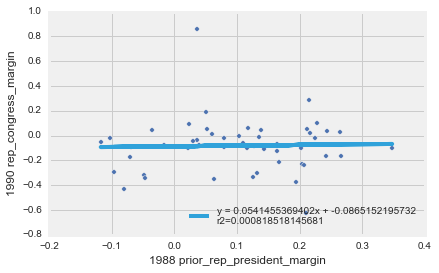

In [122]:
i = 1990
cols = ['state', 'prior_rep_president_margin', 'rep_congress_margin']
show_lin_relationship(off_pres_cycle, i, cols)